In [36]:
"""
Created on Thu Feb  6 09:00:21 2025

@author: Dr. Benjamin Vien

Demonstration:
"""
## TO INSTALL
# !pip install torch torchvision
# !pip install imageio
# !pip install matplotlib
# !pip install imageio[ffmpeg]

import os
# Set the environment variable 
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Libraries
import torch
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import time
import scipy.io as sio

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
# 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
torch.cuda.empty_cache()


CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA A10G


In [38]:
#%% Call Offline Mode
cotracker = torch.hub.load('facebookresearch/co-tracker', 'cotracker3_offline').to(device)
print(f"CoTracker3 is using device: {device}")
print("--------------------------------------------------------------")
#Have Queries Points
have_qpoints=True
have_refpoints=False

if have_qpoints:
# Load the MATLAB file
    mat_data = sio.loadmat('./matlab_files/saved_objC.mat')
    saved_objC = mat_data['saved_objC']
    saved_objC_tensor = torch.tensor(saved_objC, dtype=torch.float32).to(device) 
    saved_objC_tensor[:, :2, :] = saved_objC_tensor[:, :2, :] - 1

    print('Loaded MAT Queries Points ')
    print(type(saved_objC_tensor))
    print(saved_objC_tensor.shape)

    
if have_refpoints:
    ref_points = torch.tensor([[
        [0, 500, 550],  # For example, point 1: frame 0, x=100, y=150
        [0, 600, 650],  # For example, point 2: frame 0, x=200, y=250
        [0, 800, 850],  # For example, point 3: frame 0, x=300, y=350
        [0, 900, 850],  # For example, point 3: frame 0, x=300, y=350
    ]], dtype=torch.float32).to(device) 

combined_tensor = None
idx = 0  # Frame index

if have_qpoints:
    query_points_0 = saved_objC_tensor[:, :, idx]  # Shape: (1500, 2)
    
    # Step 1: Add frame index 0 → [0, x, y]
    frame_indices = torch.zeros((query_points_0.shape[0], 1), dtype=torch.float32, device=device)
    query_points_0_with_frame = torch.cat((frame_indices, query_points_0), dim=1)  # Shape: (1500, 3)
    print("Query Points for Frame 0:", query_points_0_with_frame.shape)  # Expected: (1500, 3)

    if not have_refpoints:
        combined_tensor = query_points_0_with_frame.unsqueeze(0).to(device)  # Make 3D (1, 1500, 3)

if have_refpoints:
    # Step 2: Ensure ref_points is properly shaped (Remove batch dimension if exists)
    ref_points_reshaped = ref_points.squeeze(0)  # Shape: (N, 3)
    print("Reference Points Shape:", ref_points_reshaped.shape)  # Expected: (N, 3)

    if not have_qpoints:
        combined_tensor = ref_points_reshaped.unsqueeze(0).to(device)  # Make 3D (1, N, 3)

if have_refpoints and have_qpoints:
    combined_tensor = torch.cat((ref_points_reshaped, query_points_0_with_frame), dim=0).to(device)  # (N + 1500, 3)
    combined_tensor = combined_tensor.unsqueeze(0)  # Make 3D: (1, N + 1500, 3)
    print("Combined Tensor Shape:", combined_tensor.shape)  # Expected: (1, N + 1500, 3)

# Print shape for verification
if combined_tensor is not None:
    print("Final Combined Tensor Shape:", combined_tensor.shape)
else:
    print("No valid points available for combination.")
    
#%%
print("--------------------------------------------------------------")

Using cache found in /home/sagemaker-user/.cache/torch/hub/facebookresearch_co-tracker_main


CoTracker3 is using device: cuda
--------------------------------------------------------------
Loaded MAT Queries Points 
<class 'torch.Tensor'>
torch.Size([1500, 2, 483])
Query Points for Frame 0: torch.Size([1500, 3])
Final Combined Tensor Shape: torch.Size([1, 1500, 3])
--------------------------------------------------------------


In [39]:
#!pip install imageio[ffmpeg]

In [40]:
print("--------------------------------------------------------------")
print("Video Loading.....")
video_path = './Input Files/IMG_7296.mp4'
frames = iio.imread(video_path, plugin='FFMPEG')  # Read video frames FFMPEG must be capitalised
print("Video Loaded!")


print("Video Loaded!")
#%% Check Frame Image
print("--------------------------------------------------------------")

--------------------------------------------------------------
Video Loading.....
Video Loaded!
Video Loaded!
--------------------------------------------------------------


In [41]:
check_frame=False
if check_frame:
    idx = 0
    H, W, _ = frames[idx].shape
    plt.figure(dpi=600)
    plt.imshow(frames[idx], extent=[0, W, H, 0], interpolation='none')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensures the aspect ratio is maintained
    plt.axis("off")
    
    if have_qpoints:
        query_points = saved_objC_tensor[:, :, idx].cpu().numpy()
        plt.scatter(query_points[:, 0], query_points[:, 1],
                    color='red', marker='.', label='Query Points', s=.5)
    
    if have_refpoints:
        ref_points_np = ref_points.cpu().numpy().squeeze(0)  # Shape: (N, 3)
    
        plt.scatter(ref_points_np[:, 1], ref_points_np[:, 2], 
                    color='green', marker='+', alpha=0.3, s=40, label="All Ref Points")
    
        ref_points_frame = ref_points_np[ref_points_np[:, 0] == idx]
        if ref_points_frame.size > 0:
            plt.scatter(ref_points_frame[:, 1], ref_points_frame[:, 2],
                        color='blue', marker='+', label='Active Ref Points', s=40)
    plt.legend()
    plt.show()
#%%

In [42]:
frames = frames[0:200:1] #[170:300:6] #[1:480:6]#Default for GPU 70 Frames/40 Gridsize
video_tensor = torch.tensor(frames).permute(0, 3, 1, 2)[None].float().to(device)  # Shape: [1, T, C, H, W]

# Check if combined_tensor exists and has valid points
if combined_tensor is not None:
    print("Before NaN removal:", combined_tensor.shape)  # Expected: (1, N, 3)
    nan_mask = torch.isnan(combined_tensor).any(dim=2)  # Shape: (1, N)
    combined_tensor = combined_tensor[:, ~nan_mask.squeeze(0), :]  # Ensure correct indexing
    print("After NaN removal:", combined_tensor.shape)  # Expected: (1, N_valid, 3)
else:
    print("combined_tensor is empty or not initialized.")


if combined_tensor is None:
    grid_size = 40  # Defines a NxN grid of points to track

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.64 GiB. GPU 0 has a total capacity of 21.98 GiB of which 4.05 GiB is free. Process 6770 has 17.92 GiB memory in use. Of the allocated memory 17.59 GiB is allocated by PyTorch, and 38.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [27]:
#%%
frames.shape
#

TypeError: 'int' object is not callable

In [ ]:
print("Starting - Displacement Tracker")
tic = time.time()  # Start timing
# video_tensor = video_tensor.half() 
# cotracker=cotracker.half()
if have_qpoints or have_refpoints:
    print('Queries Points')
    pred_tracks, pred_visibility = cotracker(video_tensor, queries=combined_tensor) 
else:
    print('Grid Points')
    pred_tracks, pred_visibility = cotracker(video_tensor, grid_size=grid_size) 
    
toc = time.time()  # End timing
elapsed_time = toc - tic
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print("--------------------------------------------------------------")
#%%
pred_tracks_np = pred_tracks[0].cpu().numpy()  # Shape: [T, N, 2]

Starting - Displacement Tracker
Queries Points
Elapsed time: 2.421402 seconds
--------------------------------------------------------------


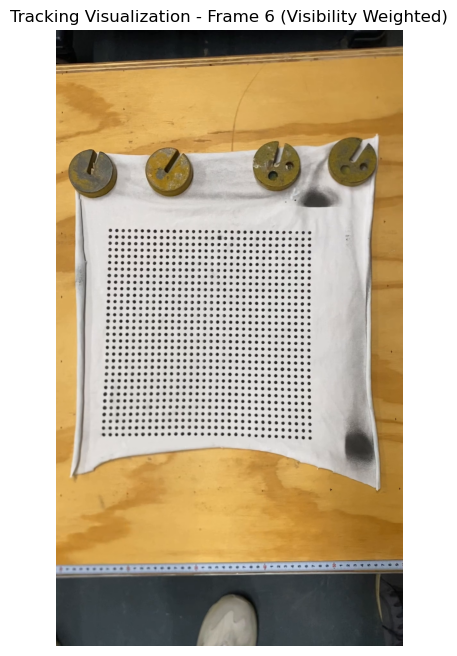

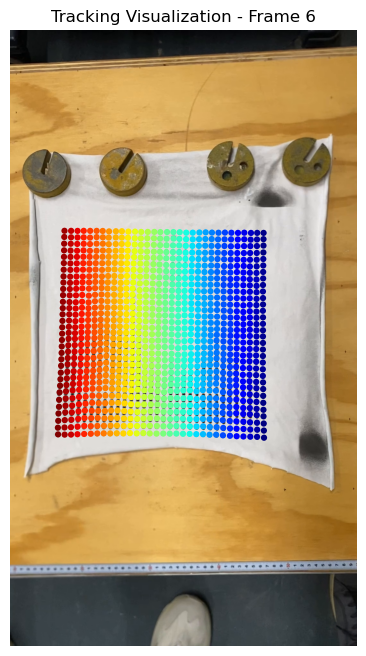

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1082, 1922) to (1088, 1936) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to ./saved_videos/ImageTracker/video.mp4


tensor([[[[[255, 255, 255,  ..., 255, 255, 255],
           [255,  44,  48,  ...,  30,  32, 255],
           [255,  47,  49,  ...,  29,  30, 255],
           ...,
           [255, 101,  95,  ...,  17,  16, 255],
           [255, 102,  95,  ...,  17,  15, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255,  48,  52,  ...,  32,  34, 255],
           [255,  51,  53,  ...,  31,  32, 255],
           ...,
           [255, 102,  96,  ...,  16,  15, 255],
           [255, 103,  96,  ...,  16,  14, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255,  56,  60,  ...,  32,  34, 255],
           [255,  59,  61,  ...,  31,  32, 255],
           ...,
           [255,  90,  84,  ...,  19,  18, 255],
           [255,  91,  84,  ...,  19,  17, 255],
           [255, 255, 255,  ..., 255, 255, 255]]],


         [[[255, 255, 255,  ..., 255, 255, 255],
           [2

In [21]:
import matplotlib.cm as cm  # Import colormap utilities

def plot_single_frame_with_gradient(frame, tracks, frame_idx):
    """
    Plots a single video frame with overlaid tracking points in gradient colors.

    Parameters:
    - frame: The image (NumPy array) of the frame to be plotted.
    - tracks: A NumPy array containing the tracked points' coordinates.
    - frame_idx: The index of the frame to visualize.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(frame)

    num_points = tracks.shape[1]  # Number of tracked points
    colors = cm.jet_r(np.linspace(0, 1, num_points))  # Generate a smooth gradient colormap

    for point_idx in range(num_points):
        x, y = tracks[frame_idx, point_idx]  # Get (x, y) coordinates
        plt.scatter(x, y, color=colors[point_idx], s=20, edgecolors='None', linewidth=0.5)  # Gradient color dots

    plt.title(f"Tracking Visualization - Frame {frame_idx}")
    plt.axis("off")
    plt.show()
    
def plot_single_frame_with_gradient_visibility(frame, tracks, visibility, frame_idx):
    """
    Plots a single video frame with tracking points, using gradient colors and visibility weighting.

    Parameters:
    - frame: The image (NumPy array) of the frame to be plotted.
    - tracks: A NumPy array containing the tracked points' coordinates.
    - visibility: A NumPy array containing visibility scores (confidence).
    - frame_idx: Index of the frame to visualize.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(frame)

    num_points = tracks.shape[1]  # Number of tracked points
    colors = cm.jet_r(np.linspace(0, 1, num_points))  # Generate gradient colormap

    # Remove batch dimension & extract visibility scores
    visibility_np = visibility.squeeze(0).cpu().numpy()  # Shape becomes [T, N]
    visibilities = visibility_np[frame_idx, :].astype(np.float32)  # Convert to float

    # Normalize visibility values between 0 and 1
    visibilities = (visibilities - visibilities.min()) / (visibilities.max() - visibilities.min() + 1e-6)

    for point_idx in range(num_points):
        x, y = tracks[frame_idx, point_idx]  # Get (x, y) coordinates
        alpha = visibilities[point_idx]  # Set transparency based on visibility
        size = 5 + 20 * alpha  # Scale dot size (more visible points are larger)

        plt.scatter(x, y, color=colors[point_idx], s=size, alpha=alpha, edgecolors='None', linewidth=0.5)

    plt.title(f"Tracking Visualization - Frame {frame_idx} (Visibility Weighted)")
    plt.axis("off")
    plt.show()

# Example usage:
frame_index = 6  # Index of the frame you want to plot
plot_single_frame_with_gradient_visibility(frames[frame_index], pred_tracks_np, pred_visibility, frame_index)
plot_single_frame_with_gradient(frames[frame_index], pred_tracks_np, frame_index)

#%%
data_to_save = {
    'video_tensor': video_tensor,
    'pred_tracks': pred_tracks,
    'pred_visibility': pred_visibility
}

# Save the dictionary to a file (e.g., "my_data.pt")
torch.save(data_to_save, 'STEP1_FULL_GPU_ALL.pt')

# loaded_data = torch.load('STEP1_HALF_GPU.pt')
# video_tensor = loaded_data['video_tensor']
# pred_tracks = loaded_data['pred_tracks']
# pred_visibility = loaded_data['pred_visibility']


#%% Call cotracker Visualizer
from cotracker.utils.visualizer import Visualizer
vis = Visualizer(save_dir="./saved_videos/ImageTracker", pad_value=1, linewidth=3)
vis.visualize(video_tensor, pred_tracks, pred_visibility)